In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import subprocess
import numpy as np
import cPickle as pickle
import os
import wave
import pylab
from scipy.optimize import minimize, fmin_l_bfgs_b as fmin
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.linalg import norm
from tslearn.metrics import dtw_path, gak
import time
import IPython.display as ipd
import librosa.display
import copy

In [3]:
def load_traj(filename, dim):
    with open(filename, 'rb') as f:
        data = np.fromfile(f, np.float32)
    return data.reshape(data.size/dim,dim)

def read_label_file(filename):
    with open(filename, 'r') as myfile:
        data = myfile.readlines()
    label_list = []
    
    for i,line in enumerate(data):
        label = {}
        label['start'] = (float(line.split()[0])/10000000)
        label['end'] = (float(line.split()[1])/10000000)
        
        p0, lp = line.split()[2].split(":")[0].split("~")
        p1, lp = lp.split("-")
        p2, lp = lp.split("+")
        p3, p4 = lp.split("=")
        label['phone'] = "-".join([p0,p1,p2,p3,p4])
        label_list.append(label)
    return label_list

'''
f='utt1'
gen_labels = read_label_file('./mass_exp/{utt}/lab/{utt}.lab'.format(utt=f))
org_labels = read_label_file('./original/lab/{utt}.lab'.format(utt=f))

print "& {} & {} & {} & {} & {} & {} \\\\\\hline".format('Start (s)', 'End (s)', 'Phone', 'Start (s)', 'End (s)', 'Phone')
for i,(g, o) in enumerate(zip(gen_labels, org_labels)):

    ophone = o['phone'].split("-")
    ophone = "{}-{}-\\textbf{{{}}}-{}-{}".format(ophone[0], ophone[1], ophone[2], ophone[3], ophone[4])
    gphone = g['phone'].split("-")
    gphone = "{}-{}-\\textbf{{{}}}-{}-{}".format(gphone[0], gphone[1], gphone[2], gphone[3], gphone[4])
    print "{} & {:1.2f} & {:1.2f} & {} & {:1.2f} & {:1.2f} & {} & {:1.2f} \\\\\\hline".format(i+1, g['start'], g['end'], gphone, o['start'], o['end'], ophone, abs((g['end'] - g['start']) - (o['end'] - o['start']))).replace('#','\\small{\\#}')
    #print "{} {}".format(i, (g['end'] - g['start']) - (o['end'] - o['start']) )  
    
    
g_list=[]
o_list=[]
for g in gen_labels:
    gphone = g['phone'].split("-")
    g_list.append(gphone[2])
    
for o in org_labels:
    ophone = o['phone'].split("-")
    o_list.append(ophone[2])
print "& Original Phonemes & " + "-".join(o_list).replace('#','\\small{\\#}') + "\\\\\\cline{2-3}"
print "& Generated Phonemes & " + "-".join(g_list).replace('#','\\small{\\#}') + "\\\\\\hline\hline"
''';

In [4]:
cmpdata = pickle.load( open( "./original/cmp/cmp_data.p", "rb" ) )

### Feature Plots

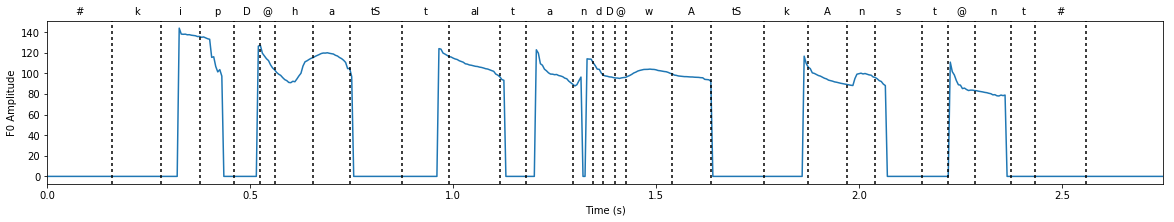

In [6]:
#F0

def f0_plot(gen_f0, labelfile, savefile=""):
    plt.clf()
    plt.figure(figsize=(20,3))
    plt.plot([0.005*x for x in range(0,len(gen_f0))], gen_f0)

    label_list = read_label_file(labelfile)
    for lab in label_list:
        plt.axvline(x=lab['end'], color='black',  dashes=[2, 2])
        plt.text((lab['end']+lab['start'])/2, 155, lab['phone'].split("-")[2], rotation=0, horizontalalignment='center', verticalalignment='bottom')
    plt.xlim((0,2.75))
    plt.xlabel('Time (s)')
    plt.ylabel('F0 Amplitude')
    #if savefile=="":
    plt.show()
    #else:
        #plt.savefig('figures/{}_f0.eps'.format(savefile), format='eps', dpi=1000, bbox_inches='tight')
f0_plot(load_traj('./mass_exp/utt1/traj/utt1.f0',1),'./mass_exp/utt1/lab/utt1.lab')
    

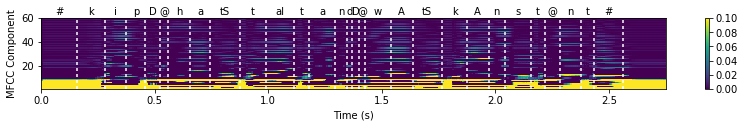

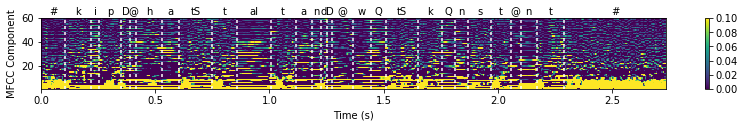

In [7]:
def feature_plot(feature, labelfile, savefile="", title="", lim=False):
    plt.figure(figsize=(14,1.3))
    label_list = read_label_file(labelfile)
    X,Y = np.meshgrid(np.linspace(0,(feature.shape[1]-1)*0.005,feature.shape[1]), np.linspace(1,feature.shape[0],feature.shape[0]))
    Z = copy.deepcopy(feature)
    if(lim==True):
        lima=0.1
        limb=0
        Z[Z>lima]=lima
        Z[Z<limb]=limb

    for lab in label_list:
        plt.axvline(x=lab['end'], color='white',  dashes=[2, 2])
        plt.text((lab['end']+lab['start'])/2, feature.shape[0]+1, lab['phone'].split("-")[2], rotation=0, horizontalalignment='center', verticalalignment='bottom')
    
    ylabel = 'MFCC Component' if feature.shape[0]==60 else 'APF Component'
    plt.xlim([0, (feature.shape[1]-1)*0.005])
    plt.ylabel(ylabel)
    plt.xlabel('Time (s)')
    plt.pcolormesh(X,Y,Z)
    plt.colorbar()
    plt.title(title, y=1.15)
    #if savefile=="":
    plt.show()
    #else:
        #plt.savefig('figures/{}.eps'.format(savefile), format='eps', dpi=250, bbox_inches='tight')
    plt.clf()
#cmpdata = pickle.load( open( "./original/cmp/cmp_data.p", "rb" ) )
feature_plot(load_traj('./mass_exp/utt1/traj/utt1.mcep',60).T,'./mass_exp/utt1/lab/utt1.lab', lim=True)
feature_plot(cmpdata['utt1']['mcep'].copy(), './original/lab/utt1.lab', lim=True)

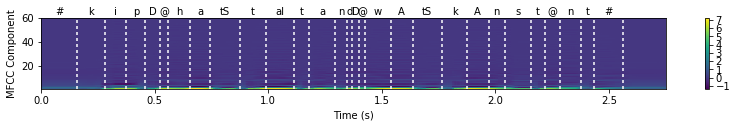

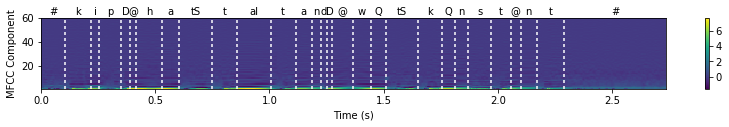

In [8]:
feature_plot(load_traj('./mass_exp/utt1/traj/utt1.mcep',60).T,'./mass_exp/utt1/lab/utt1.lab')
feature_plot(cmpdata['utt1']['mcep'], './original/lab/utt1.lab')

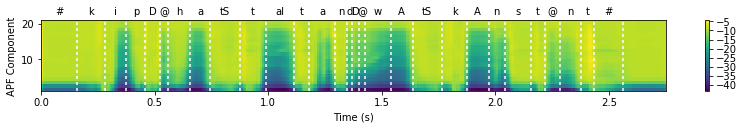

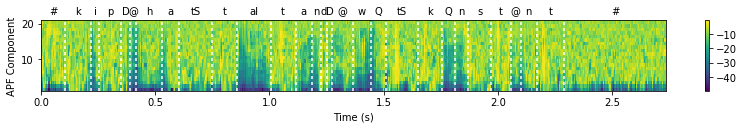

In [31]:
feature_plot(load_traj('./mass_exp/utt1/traj/utt1.apf',21).T,'./mass_exp/utt1/lab/utt1.lab')
feature_plot(cmpdata['utt1']['apf'], './original/lab/utt1.lab')

In [57]:
feature_plot(load_traj('./mass_exp/{file_n}/traj/{file_n}.mcep'.format(file_n=f), 60).T, './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), 'p_synth', 'a) Synthesized Trajectory')
feature_plot(load_traj('./mass_exp/{file_n}/wav/mcep_generation/poe_una/{file_n}.mcep'.format(file_n=f), 60).T, './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), 'p_poe', 'b) Experts Trajectory')
feature_plot(load_traj('./mass_exp/{file_n}/wav/mcep_generation/gv_expert_una/{file_n}.mcep'.format(file_n=f), 60).T, './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), 'p_gve', 'c) Global Variance - Expert Trajectory')
feature_plot(load_traj('./mass_exp/{file_n}/wav/mcep_generation/gv_constraint_una/{file_n}.mcep'.format(file_n=f), 60).T, './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), 'p_gvc', 'd) Global Variance - Constraint Trajectory')
feature_plot(cmpdata['utt1']['mcep'].copy(), './original/lab/utt1.lab', 'p_org', 'e) Original Trajectory')

### Spectogram

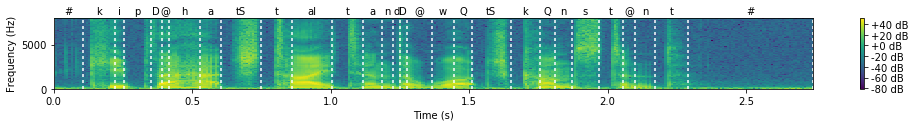

In [32]:
def get_wav_info(wav_file):
    wav = wave.open(wav_file, 'r')
    frames = wav.readframes(-1)
    sound_info = pylab.fromstring(frames, pylab.int16)
    frame_rate = wav.getframerate()
    wav.close()
    return sound_info, frame_rate
'''
def gen_spectogram(wav_filename, labelfile):
    label_list = read_label_file(labelfile)
    
    sound_info, frame_rate = get_wav_info(wav_filename)
    pylab.figure(figsize=(28, 1))
    plt.subplot(1,2,1)
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.specgram(sound_info, Fs=frame_rate)
    pylab.colorbar(format='%+2.0f dB')
    for lab in label_list:
        plt.axvline(x=lab['end'], color='white')
        plt.text((lab['end']+lab['start'])/2, 16000, lab['phone'], rotation=90)
    
    y, sr = librosa.load(wav_filename,mono=True)
    plt.subplot(1,2,2)
    librosa.display.waveplot(y, sr=sr)
    for lab in label_list:
        plt.axvline(x=lab['end'], color='gray')
        plt.text((lab['end']+lab['start'])/2, 1.5, lab['phone'], rotation=90)
    plt.show()
    plt.clf()
    ipd.display(ipd.Audio(wav_filename))
'''
def gen_spectogram(wav_filename, labelfile, savefile="", title=""):
    label_list = read_label_file(labelfile)
    
    sound_info, frame_rate = get_wav_info(wav_filename)
    pylab.figure(figsize=(17,1.3))
    pylab.xlabel('Time (s)')
    pylab.ylabel('Frequency (Hz)')
    pylab.specgram(sound_info, Fs=frame_rate, scale='dB')
    pylab.colorbar(format='%+2.0f dB')
    for lab in label_list:
        plt.axvline(x=lab['end'], color='white',  dashes=[2, 2])
        plt.text((lab['end']+lab['start'])/2, 8200, lab['phone'].split("-")[2], rotation=0, horizontalalignment='center', verticalalignment='bottom')
    pylab.xlim([0,label_list[-1]['end']])
    if title!="":
        plt.title(title, y=1.15)
    if savefile=="":
        pylab.show()
    else:
        plt.savefig('figures/{}_spec.eps'.format(savefile), format='eps', dpi=250, bbox_inches='tight')
    '''
    plt.clf()
    plt.figure(figsize=(14,2))
    y, sr = librosa.load(wav_filename,mono=True)
    librosa.display.waveplot(y, sr=sr)
    for lab in label_list:
        plt.axvline(x=lab['end'], color='black',  dashes=[2, 2])
        plt.text((lab['end']+lab['start'])/2, max(y)*1.2, lab['phone'].split("-")[2], rotation=0, horizontalalignment='center', verticalalignment='bottom')
    
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    if savefile=="":
        plt.show()
    else:
        plt.savefig('figures/{}_wave.eps'.format(savefile), format='eps', dpi=1000, bbox_inches='tight')
    plt.clf()
    '''
    ipd.display(ipd.Audio(wav_filename))
    

gen_spectogram('./original/wav/utt1.wav','./original/lab/utt1.lab')
f='utt1'

## Original

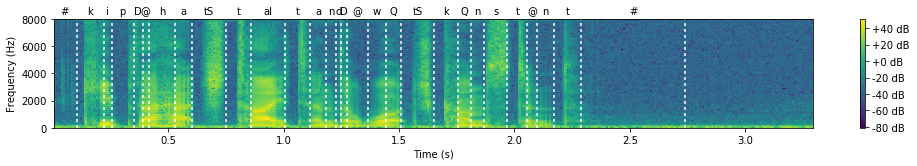

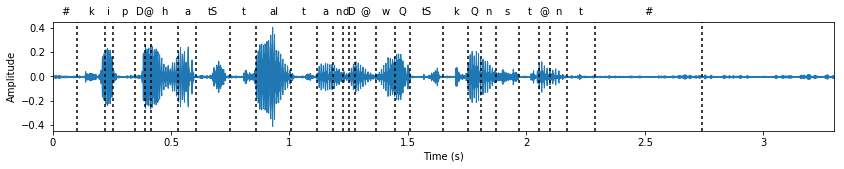

In [369]:
gen_spectogram('./original/wav/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))

## Standard, no F0 and Original Label Timings

Full


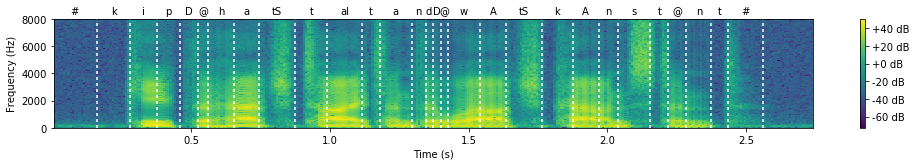

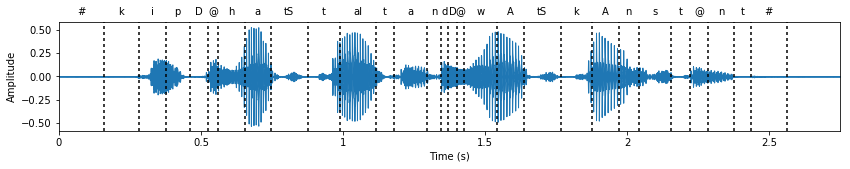

No F0


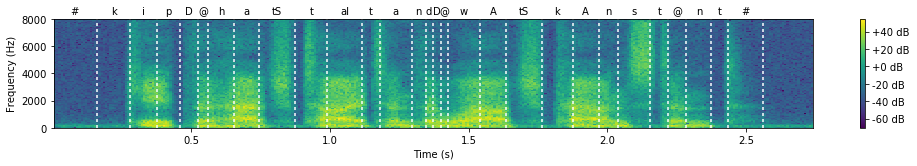

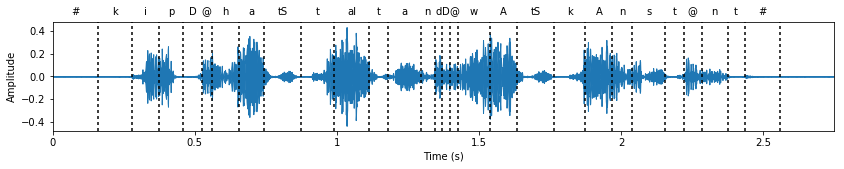

Label Matched


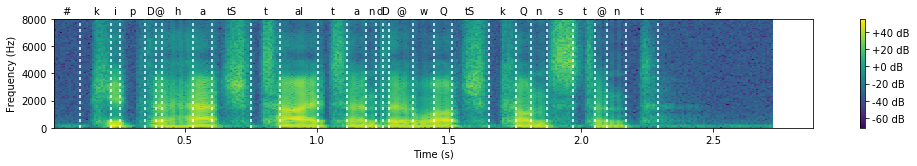

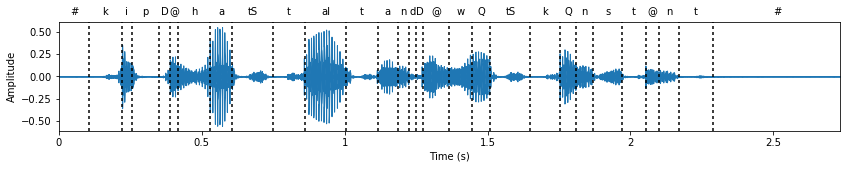

In [374]:
print "Full"
gen_spectogram('./mass_exp/{file_n}/wav/unaligned/full/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
print "No F0"
gen_spectogram('./mass_exp/{file_n}/wav/unaligned/nof0/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
print "Label Matched"
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/none/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))

## Addition of original features to generated waveforms

**None**

**F0**

**APF**

**MCEP**

**F0-MCEP**

**F0-APF**

**MCEP-APF**

**All**

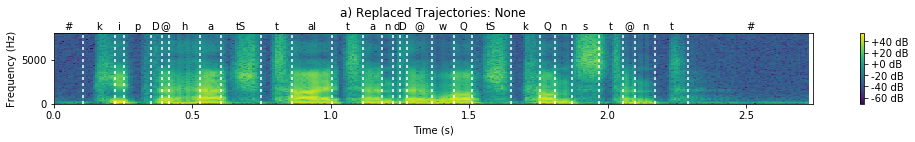

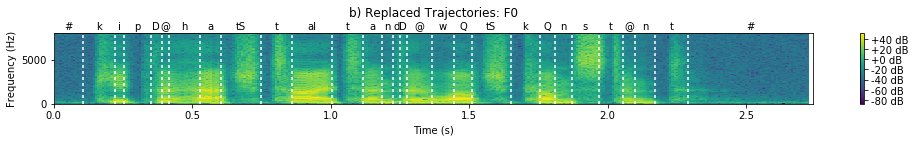

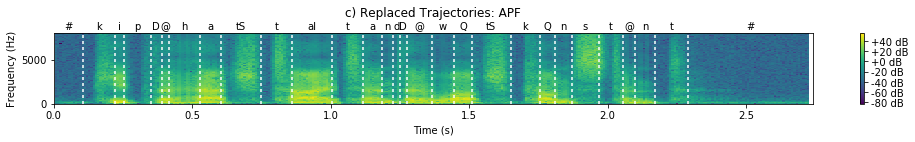

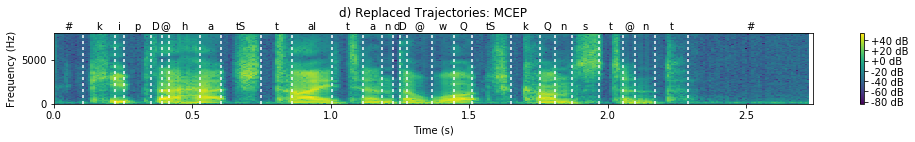

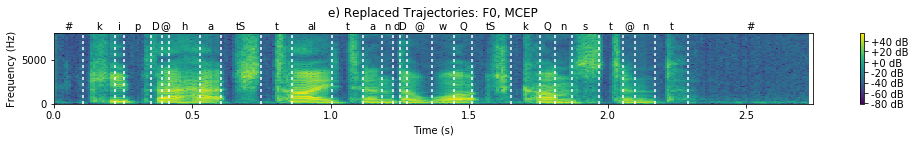

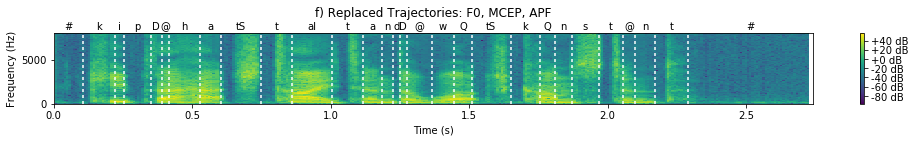

In [502]:
ipd.display(ipd.Markdown("**None**"))
gen_spectogram('./mass_exp/{file_n}/traj-dur/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f),'7_none', 'a) Replaced Trajectories: None')
ipd.display(ipd.Markdown("**F0**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/f0/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_f0', 'b) Replaced Trajectories: F0')
ipd.display(ipd.Markdown("**APF**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/apf/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_apf', 'c) Replaced Trajectories: APF')
ipd.display(ipd.Markdown("**MCEP**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/mcep/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_mcep', 'd) Replaced Trajectories: MCEP')
ipd.display(ipd.Markdown("**F0-MCEP**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/f0_mcep/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_f0_mcep', 'e) Replaced Trajectories: F0, MCEP')
ipd.display(ipd.Markdown("**F0-APF**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/f0_apf/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_f0_apf', 'f) Replaced Trajectories: F0, APF')
ipd.display(ipd.Markdown("**MCEP-APF**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/mcep_apf/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_mcep_apf', 'g) Replaced Trajectories: MCEP, APF')
ipd.display(ipd.Markdown("**All**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison_fa/f0_mcep_apf/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_all', 'f) Replaced Trajectories: F0, MCEP, APF')

**None**

**F0**

**APF**

**MCEP**

**F0-MCEP**

**All**

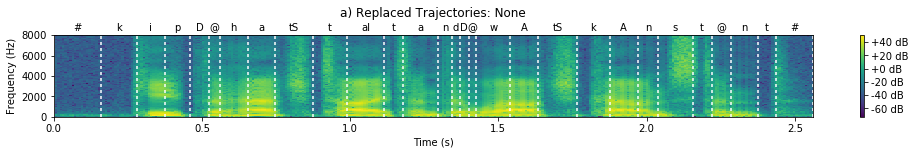

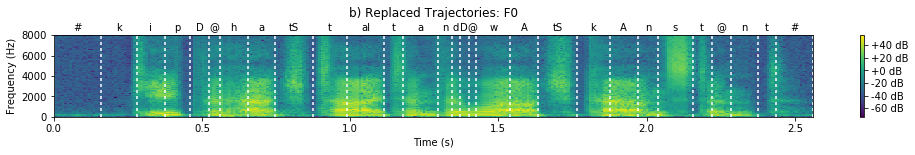

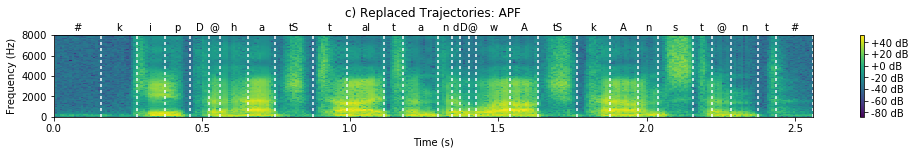

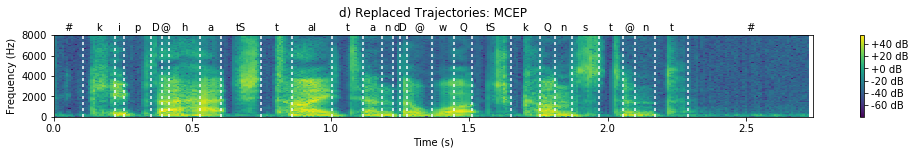

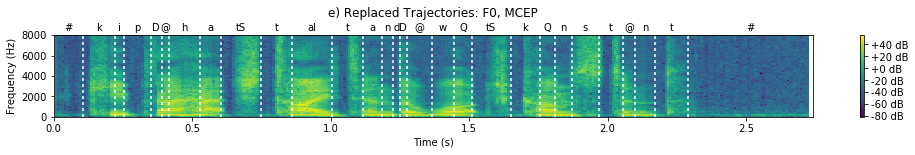

In [495]:
ipd.display(ipd.Markdown("**None**"))
gen_spectogram('./mass_exp/{file_n}/wav/unaligned/full/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), '7_none', 'a) Replaced Trajectories: None')
ipd.display(ipd.Markdown("**F0**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/f0/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), '7_f0', 'b) Replaced Trajectories: F0')
ipd.display(ipd.Markdown("**APF**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/apf/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f), '7_apf', 'c) Replaced Trajectories: APF')
ipd.display(ipd.Markdown("**MCEP**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/mcep/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_mcep', 'd) Replaced Trajectories: MCEP')
ipd.display(ipd.Markdown("**F0-MCEP**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/f0_mcep/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_f0_mcep', 'e) Replaced Trajectories: F0, MCEP')
#ipd.display(ipd.Markdown("**F0-APF**"))
#gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/f0_apf/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
#ipd.display(ipd.Markdown("**MCEP-APF**"))
#gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/mcep_apf/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
ipd.display(ipd.Markdown("**All**"))
gen_spectogram('./mass_exp/{file_n}/wav/feature_comparison/f0_mcep_apf/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f), '7_all', 'f) Replaced Trajectories: F0, MCEP, APF')

## Generated Trajectories

In [ ]:
feature_plot(load_traj('./mass_exp/utt1/traj/utt1.mcep',60).T,'./mass_exp/utt1/lab/utt1.lab')

In [519]:
f='utt7'

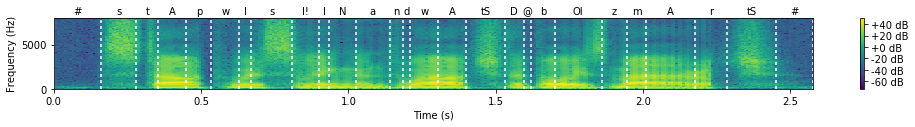

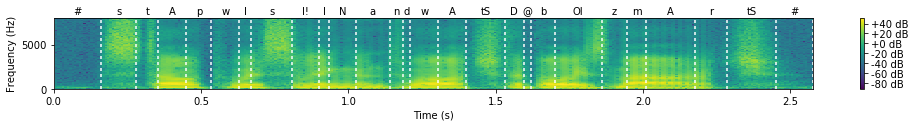

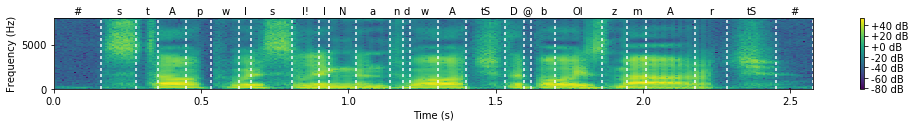

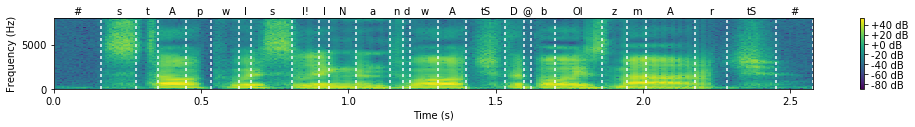

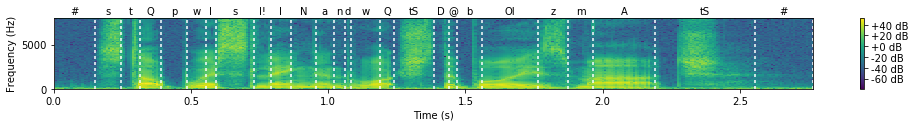

In [520]:
gen_spectogram('./mass_exp/{file_n}/traj/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/poe_una/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/gv_expert_una/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/gv_constraint_una/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./original/wav/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))

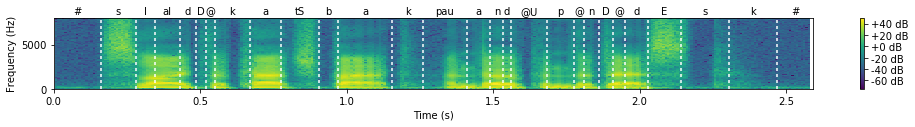

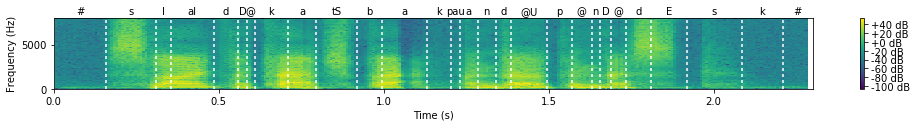

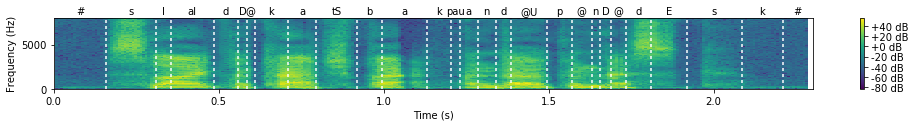

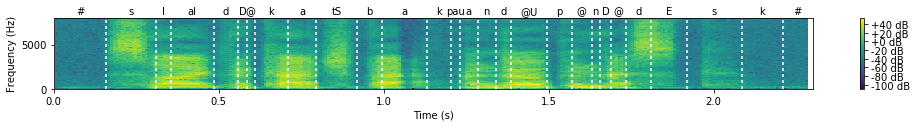

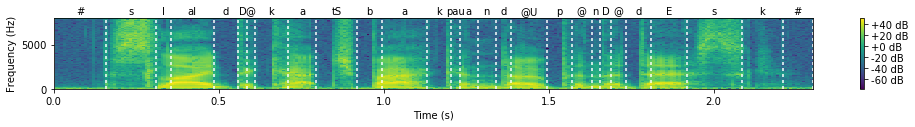

In [513]:
gen_spectogram('./mass_exp/{file_n}/traj/{file_n}.wav'.format(file_n=f), './mass_exp/{file_n}/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/poe_org/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/gv_expert_org/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./mass_exp/{file_n}/wav/mcep_generation/gv_constraint_org/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))
gen_spectogram('./original/wav/{file_n}.wav'.format(file_n=f), './original/lab/{file_n}.lab'.format(file_n=f))